In [1]:
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
pd.options.display.float_format = '{:,.2f}'.format
df_train=pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
df_test=pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

#### We break the main rule! We combine the test and training part.Because there is only one ship and the passengers from the general groups ended up in different parts.

In [2]:
df_train = pd.concat([df_train.drop(['Transported'], axis=1), df_test], axis=0,)
df_train.reset_index(drop= True , inplace= True)

combine = [df_train]
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,"3,576.00",0.00,"6,715.00",49.00,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,"1,283.00",371.00,"3,329.00",193.00,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines


In [3]:
# Since we removed the target from our training set. We make a helper function.
Target = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
def update(TargetUpdate):
    tempdf = df_train[:8693].copy()
    TargetUpdate = pd.concat([tempdf, TargetUpdate['Transported']], axis = 1)
    return TargetUpdate

In [4]:
# We divide our signs and create new ones. 
# Later it turns out that half of them are not needed. But I want to share my train of thought.

from collections import Counter
for dataset in combine:
    dataset['ID1'] = dataset.PassengerId.str.split("_", n=1, expand=True)[0]
    dataset['ID2'] = dataset.PassengerId.str.split("_", n=1, expand=True)[1]
    dataset['ID1'] = dataset.PassengerId.str.split("_", n=1, expand=True)[0]
    CountID = Counter(dataset['ID1'])
    dataset['ID1_count'] = dataset['ID1'].map(CountID)
    dataset['ID1'] = dataset['ID1'].astype(int)
    dataset['ID2'] = dataset['ID2'].astype(int)
    dataset['Name1'] = dataset.Name.str.split(" ", n=1, expand=True)[0]
    CountName1 = Counter(dataset['Name1'])
    dataset['Name1Count'] = dataset['Name1'].map(CountName1)
    dataset['NameLen1'] = dataset['Name1'].str.count('\S')
    dataset['Name2'] = dataset.Name.str.split(" ", n=1, expand=True)[1]
    CountName2 = Counter(dataset['Name2'])
    dataset['Name2Count'] = dataset['Name2'].map(CountName2)
    dataset['NameLen2'] = dataset['Name2'].str.count('\S')
    dataset['NameLen'] =  dataset['NameLen1']+dataset['NameLen2']
    dataset['VIP'] = dataset['VIP'].replace(np.nan, -1).astype(int)
    dataset['VIP'] = dataset['VIP'].replace(-1, np.nan)
    dataset['CryoSleep'] = dataset['CryoSleep'].replace(np.nan, -1).astype(int)
    dataset['CryoSleep'] = dataset['CryoSleep'].replace(-1, np.nan)
    dataset.drop(['PassengerId','Name'], axis = 1 , inplace = True)

# CABIN

### People who flew in the same group are likely to fly in the same cabin, so we are looking for the cabin number.

In [5]:
print('#Lost Before:', df_train['Cabin'].isnull().sum())
CabinValue = df_train[df_train['Cabin'].notnull()][['ID1','Cabin']]
CabinDict = dict(zip(CabinValue['ID1'], CabinValue['Cabin']))
for dataset in combine:
    index = dataset.loc[(dataset['Cabin'].isnull())].index
    dataset.loc[index, 'Cabin'] = dataset.iloc[index,:]['ID1'].map(CabinDict)
print('#Lost After:', df_train['Cabin'].isnull().sum())

#Lost Before: 299
#Lost After: 162


### The same situation with namesakes.

In [6]:
print('#Lost Before:', df_train['Cabin'].isnull().sum())
NameValue = df_train[(df_train['Cabin'].notnull())&(df_train['Name2'].notnull())][['Name2','Cabin']]
NameDict = dict(zip(NameValue['Name2'], NameValue['Cabin']))
for dataset in combine:
    index = dataset.loc[(dataset['Cabin'].isnull())].index
    dataset.loc[index, 'Cabin'] = dataset.iloc[index,:]['Name2'].map(NameDict)
print('#Lost After:', df_train['Cabin'].isnull().sum())

#Lost Before: 162
#Lost After: 5


In [7]:
# The rest of the values ​​are entered at random.
df_train['Cabin'].fillna('E/500/S',inplace=True)
print('#Lost After:', df_train['Cabin'].isnull().sum())

#Lost After: 0


# We create a new sign (the ratio of the group to the cabin number)

In [8]:
for dataset in combine:
    dataset['Cabin1'] = dataset.Cabin.str.split("/", n=2, expand=True)[0]
    dataset['Cabin2'] = dataset.Cabin.str.split("/", n=2, expand=True)[1]
    dataset['Cabin2'] = dataset['Cabin2'].replace(np.nan, -1).astype(int)
    dataset['Cabin2'] = dataset['Cabin2'].replace(-1, np.nan)
    dataset['Cabin3'] = dataset.Cabin.str.split("/", n=2, expand=True)[2]
    dataset['Cabin3'] = dataset['Cabin3'].map({'S':1, "P":0}) 
    dataset['RatioIDCabin'] = dataset['ID1']/dataset['Cabin2']

### We look at the effect of the cockpit on survival. This is where our help function comes in handy.

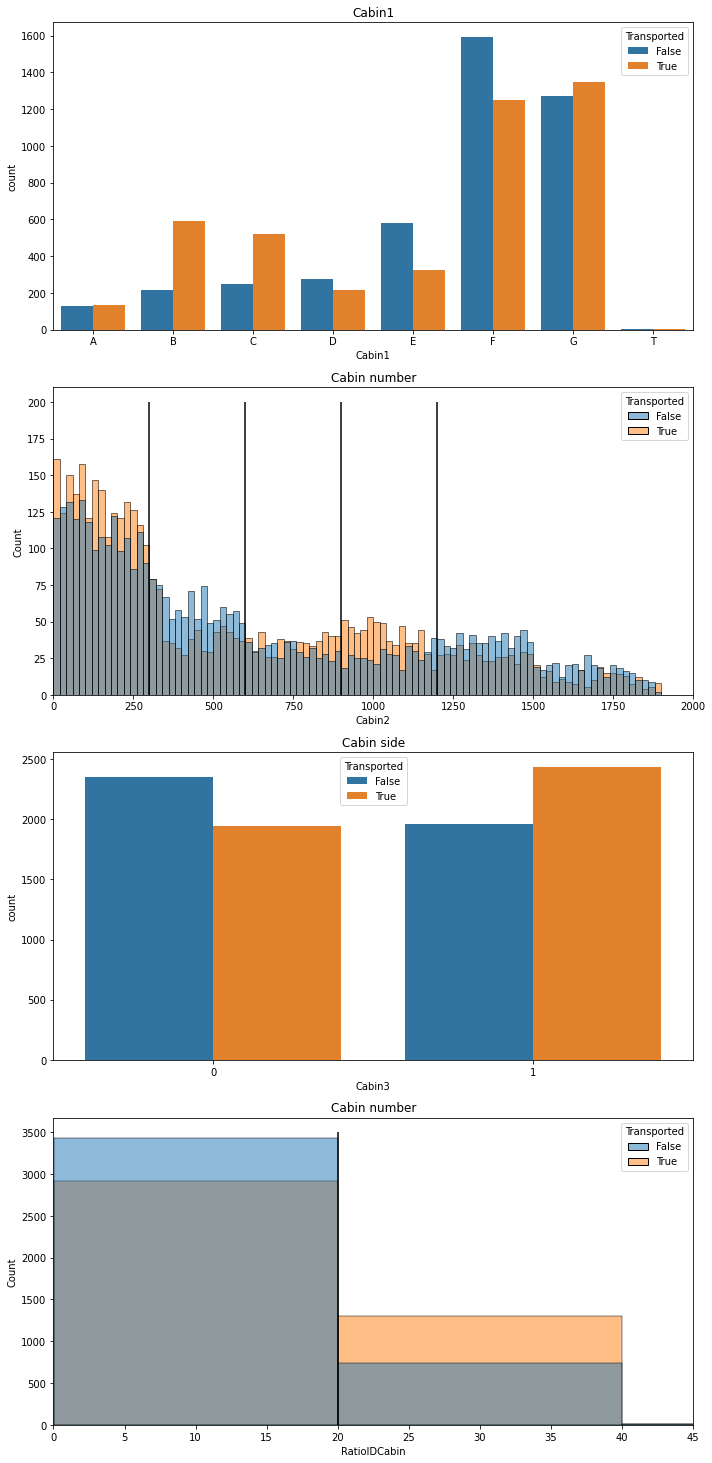

In [9]:
# # Plot distribution of new features
Target = update(Target)
fig=plt.figure(figsize=(10,20))
plt.subplot(4,1,1)
sns.countplot(data=Target, x='Cabin1', hue='Transported', 
              order=['A','B','C','D','E','F','G','T']
             )
plt.title('Cabin1')

plt.subplot(4,1,2)
sns.histplot(data=Target, x='Cabin2', hue='Transported',binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(4,1,3)
sns.countplot(data=Target, x='Cabin3', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

plt.subplot(4,1,4)
sns.histplot(data=Target, x='RatioIDCabin', hue='Transported',binwidth=20)
plt.vlines(20, ymin=0, ymax=3500, color='black')
plt.title('Cabin number')
plt.xlim([0,45]);

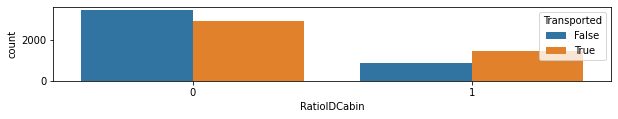

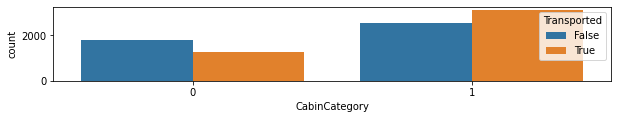

In [10]:
# Converting to binary features
for dataset in combine:
    dataset['RatioIDCabin'] = dataset['RatioIDCabin'].apply(lambda x: 1 if x >20 else 0)
    dataset['CabinCategory']  = np.nan
    for i in range(7):
        dataset.loc[(dataset['Cabin2'] >= 300*i) & (dataset['Cabin2'] < 300*(i+1)),'CabinCategory'] = (i+1)
    dataset['CabinCategory'] = dataset['CabinCategory'].apply(lambda x: 1 if x in {1,3,4} else 0)
    
Target = update(Target)
fig=plt.figure(figsize=(10,3))
plt.subplot(2,1,1)
sns.countplot(data=Target, x='RatioIDCabin', hue='Transported');

fig=plt.figure(figsize=(10,3))
plt.subplot(2,1,2)
sns.countplot(data=Target, x='CabinCategory', hue='Transported');

# HOMEPLANET

HomePlanet  Earth  Europa  Mars
Cabin1                         
A               0     355     0
B               0    1157     0
C               0    1111     0
D               0     300   418
E             604     200   524
F            2473       0  1742
G            3788       0     0
T               0      10     0


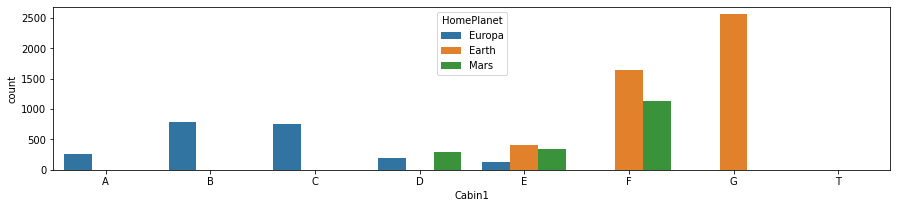

In [11]:
fig=plt.figure(figsize=(15,3))
plt.subplot(1,1,1)

sns.countplot(data=Target, x='Cabin1', hue='HomePlanet', order=['A','B','C','D','E','F','G','T']);
print(pd.crosstab(df_train['Cabin1'], df_train['HomePlanet'])) 

In [12]:
print('#Lost after:', df_train['HomePlanet'].isnull().sum())
for dataset in combine:
    CabEuropa = {'A', 'B', 'C','T'}
    indexHomeCab1G = dataset.loc[(df_train['Cabin1'].isin(CabEuropa)) & (df_train['HomePlanet'].isnull())].index
    for i in indexHomeCab1G:
        dataset.loc[dataset['HomePlanet'].index == i, 'HomePlanet'] = 'Europa'
    CabEarth = {'G'}
    indexHomeCab1G = dataset.loc[(df_train['Cabin1'].isin(CabEarth)) & (df_train['HomePlanet'].isnull())].index
    for i in indexHomeCab1G:
        dataset.loc[dataset['HomePlanet'].index == i, 'HomePlanet'] = 'Earth'
print('#Lost before:', df_train['HomePlanet'].isnull().sum())

#Lost after: 288
#Lost before: 158


### People from the same group, in the same cabin and namesakes very often start from the same planet

In [13]:
print('#Lost after:', df_train['HomePlanet'].isnull().sum())
PlanetName = dataset[dataset['HomePlanet'].notnull()]['HomePlanet'].unique() #Имеена планет
for dataset in combine:
    for i in PlanetName:
        # ID = HomePlanet
        Planet_ID = dataset.loc[(dataset['ID1'].notnull()) & (dataset['HomePlanet']==i)]['ID1'].values
        IndexPlanet = dataset.loc[(dataset['ID1'].isin(Planet_ID))].index
        for ii in IndexPlanet:
            dataset.loc[dataset['HomePlanet'].index == ii, 'HomePlanet'] = i
        # Cabin = HomePlanet
        Planet_ID = dataset.loc[(dataset['Cabin'].notnull()) & (dataset['HomePlanet']==i)]['Cabin'].values
        IndexPlanet = dataset.loc[(dataset['Cabin'].isin(Planet_ID))].index
        for ii in IndexPlanet:
            dataset.loc[dataset['HomePlanet'].index == ii, 'HomePlanet'] = i
        # SecondName = HomePlanet
        Planet_ID = dataset.loc[(dataset['Name2'].notnull()) & (dataset['HomePlanet']==i)]['Name2'].values
        IndexPlanet = dataset.loc[(dataset['Name2'].isin(Planet_ID))].index
        for ii in IndexPlanet:
            dataset.loc[dataset['HomePlanet'].index == ii, 'HomePlanet'] = i
print('#Lost before:', df_train['HomePlanet'].isnull().sum())
df_train.drop(['Cabin'],axis=1, inplace = True)

#Lost after: 158
#Lost before: 10


In [14]:
### The remaining planets will be filled with an error
print('#Lost after:', df_train['HomePlanet'].isnull().sum())
for dataset in combine:
    indexHomeCab1D = dataset.loc[(df_train['Cabin1'].isin({'D','E'})) & (df_train['HomePlanet'].isnull())].index
    for i in indexHomeCab1D:
        dataset.loc[dataset['HomePlanet'].index == i, 'HomePlanet'] = 'Europa'
    indexHomeCab = dataset.loc[(df_train['HomePlanet'].isnull())].index
    for i in indexHomeCab:
        dataset.loc[dataset['HomePlanet'].index == i, 'HomePlanet'] = 'Earth'
print('#Lost before:', df_train['HomePlanet'].isnull().sum())

#Lost after: 10
#Lost before: 0


# Name

### According to Google, female names end in 'e','a','y'. We are trying to separate men and women. Question for reflection, how to separate the names of the Martians ... do they have a gender?

In [15]:
name = df_train[df_train['Name1'].notnull()]['Name1'].values
suffix = ('e','a','y')
female = [f for f in name if f.endswith(suffix)]
for dataset in combine:
    index = dataset.loc[(dataset['Name1'].isin(female))].index
    dataset['NameSex'] = 0
    for i in index:
        dataset.loc[dataset['Name1'].index == i, 'NameSex'] = 1
df_train.drop(['Name1', 'Name2'], axis = 1 , inplace = True)

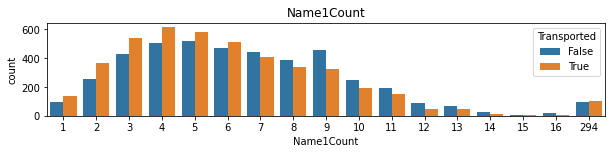

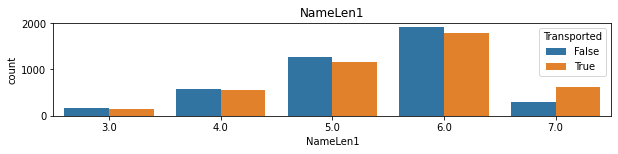

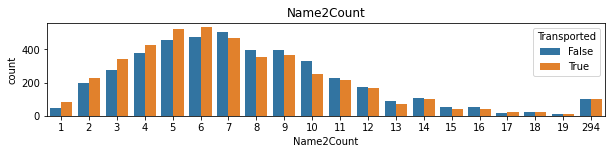

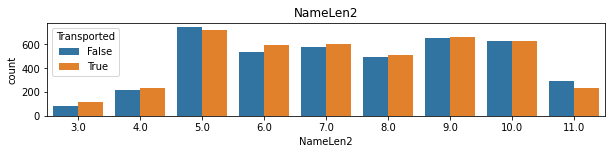

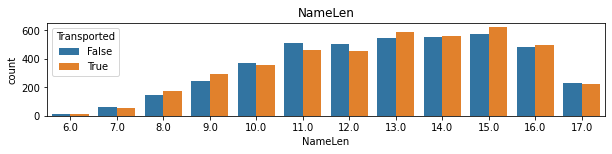

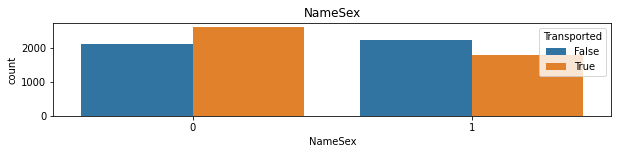

In [16]:
Target = update(Target)
Names = [f for f in Target.columns if 'Name' in f]
for i, Name in enumerate(Names):
    fig=plt.figure(figsize=(10,12))
    plt.subplot(len(Names),1,(i+1))
    sns.countplot(data=Target, x=Name, hue='Transported')
    plt.title(Name)

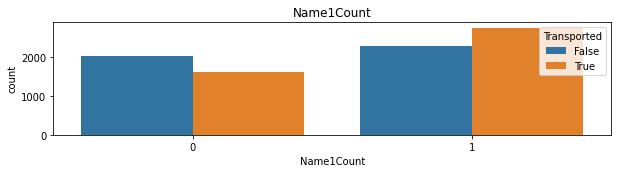

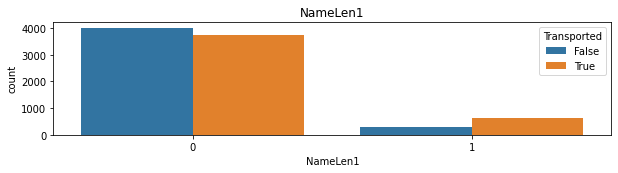

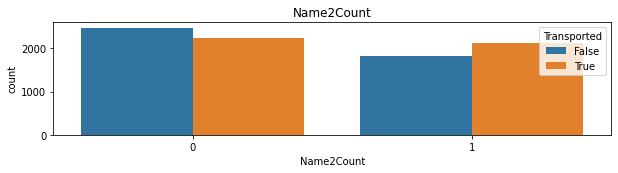

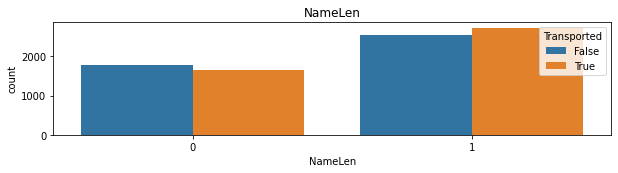

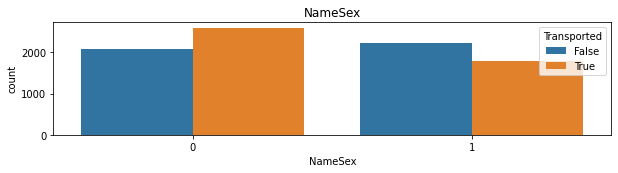

In [17]:
# Converting to binary features
for dataset in combine:
    dataset['Name1Count'] = dataset['Name1Count'].apply(lambda x: 1 if x <=6 else 0)
    dataset['NameLen1'] = dataset['NameLen1'].apply(lambda x: 1 if x==7 else 0)
    dataset['Name2Count'] = dataset['Name2Count'].apply(lambda x: 1 if x <=6 else 0)
    dataset['NameLen'] = dataset['NameLen'].apply(lambda x: 1 if x in {8,9,13,14,15,16} else 0)
    dataset.drop(['NameLen2'],axis =1, inplace = True)
Target = update(Target)
Names = [f for f in Target.columns if 'Name' in f]
for i, Name in enumerate(Names):
    fig=plt.figure(figsize=(10,12))
    plt.subplot(len(Names),1,(i+1))
    sns.countplot(data=Target, x=Name, hue='Transported')
    plt.title(Name)

In [18]:
Names = [f for f in df_train.columns if 'Name' in f]
for Name in Names:
    print(f'#Lost before: {Name}:{df_train[Name].isnull().sum()}')

#Lost before: Name1Count:0
#Lost before: NameLen1:0
#Lost before: Name2Count:0
#Lost before: NameLen:0
#Lost before: NameSex:0


# ID

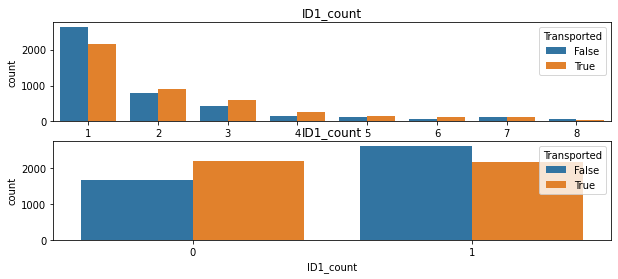

In [19]:
fig=plt.figure(figsize=(10,4))
plt.subplot(2,1,1)
sns.countplot(data=Target, x='ID1_count', hue='Transported')
plt.title('ID1_count')

# Those who were outside the group were less likely to survive

for dataset in combine:
    dataset['ID1_count'] = dataset['ID1_count'].apply(lambda x: 1 if x in {1} else 0)

Target = update(Target)
plt.subplot(2,1,2)
sns.countplot(data=Target, x='ID1_count', hue='Transported')
plt.title('ID1_count');


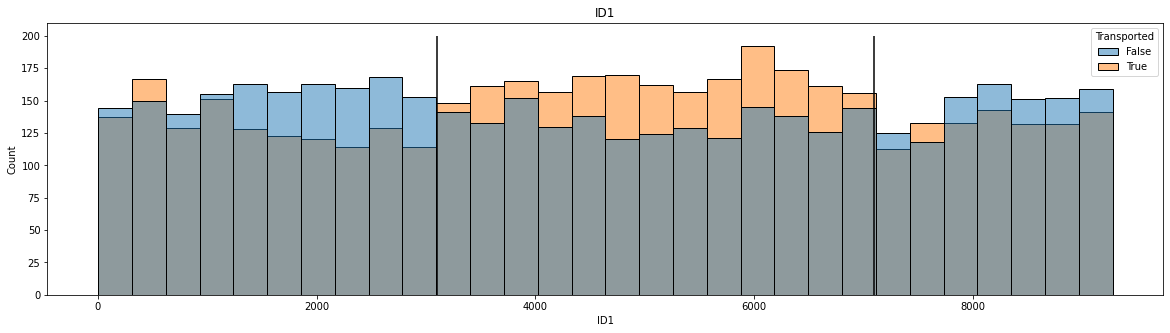

In [20]:
Target = update(Target)
fig=plt.figure(figsize=(20,5))
ax=fig.add_subplot(1,1,1)
sns.histplot(data=Target, x='ID1', axes=ax, bins=30, kde=False, hue='Transported')
plt.vlines(3100, ymin=0, ymax=200, color='black')
plt.vlines(7100, ymin=0, ymax=200, color='black')
ax.set_title('ID1');

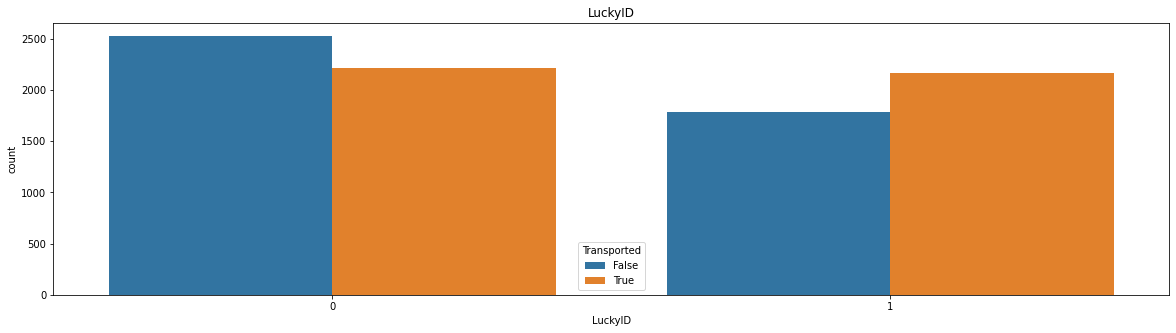

In [21]:
# Converting to binary features
for dataset in combine:
    dataset['LuckyID'] = 0
    dataset.loc[(dataset['ID1']>3000) & (dataset['ID1']<7100),'LuckyID']= 1
Target = update(Target)
fig=plt.figure(figsize=(20,5))
plt.subplot(1,1,1)
sns.countplot(data=Target, x='LuckyID', hue='Transported')
plt.title('LuckyID');

### ID is the only feature that has no gaps. It would be right, of course, to dance around him. But I figured it out late and haven't found good dependencies yet.

# AGE

### Children don't spend money.

In [22]:
MoneyName = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df_train['Money'] = df_train[MoneyName].sum(axis=1)
df_train['Money1']=1
df_train.loc[df_train['Money']<1, 'Money1']=0  

### We group the signs and fill in the age according to the average of the signs.

In [23]:
print(df_train.groupby(['HomePlanet','Money1','ID1_count','Cabin1'])['Age'].median().unstack().fillna(0))
print('#Lost before:', df_train['Age'].isnull().sum())
index=df_train.loc[df_train['Age'].isnull(),'Age'].index
df_train.loc[df_train['Age'].isnull(),'Age']=df_train.groupby(['HomePlanet','Money1','ID1_count','Cabin1'])['Age'].transform(lambda x: x.fillna(x.median()))[index]
print('#Lost after:', df_train['Age'].isnull().sum()) 

Cabin1                          A     B     C     D     E     F     G     T
HomePlanet Money1 ID1_count                                                
Earth      0      0          0.00  0.00  0.00  0.00  7.50 16.00  8.00  0.00
                  1          0.00  0.00  0.00  0.00 21.00 27.00 23.00  0.00
           1      0          0.00  0.00  0.00  0.00 24.00 25.00 28.00  0.00
                  1          0.00  0.00  0.00  0.00 25.00 24.00 26.00  0.00
Europa     0      0         30.00 27.00 28.50 27.00 28.00 30.00  0.00  0.00
                  1         37.50 34.00 34.50 32.00 33.00 18.00  0.00  0.00
           1      0         35.00 34.00 33.00 33.00 34.00  0.00  0.00 44.00
                  1         35.00 36.00 36.00 34.00 33.00  0.00  0.00 35.00
Mars       0      0          0.00  0.00  0.00 29.50 26.00 18.00  0.00  0.00
                  1          0.00  0.00  0.00 28.00 30.00 30.00  0.00  0.00
           1      0          0.00  0.00  0.00 30.00 29.00 29.00  0.00  0.00
            

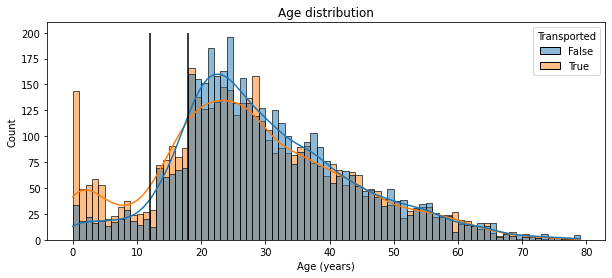

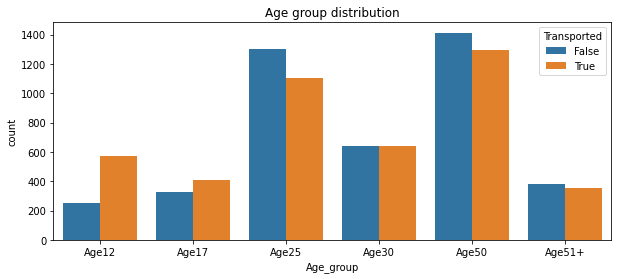

In [24]:
Target = update(Target)

plt.figure(figsize=(10,4))


sns.histplot(data=Target, x='Age', hue='Transported', binwidth=1, kde=True)
plt.vlines(12, ymin=0, ymax=200, color='black')
plt.vlines(18, ymin=0, ymax=200, color='black')


plt.title('Age distribution')
plt.xlabel('Age (years)')

for dataset in combine:
    dataset['Age_group']=np.nan
    dataset.loc[dataset['Age']<=12,'Age_group']='Age12'
    dataset.loc[(dataset['Age']>12) & (dataset['Age']<18),'Age_group']='Age17'
    dataset.loc[(dataset['Age']>=18) & (dataset['Age']<=25),'Age_group']='Age25'
    dataset.loc[(dataset['Age']>25) & (dataset['Age']<=30),'Age_group']='Age30'
    dataset.loc[(dataset['Age']>30) & (dataset['Age']<=50),'Age_group']='Age50'
    dataset.loc[dataset['Age']>50,'Age_group']='Age51+'
#     dataset.drop(['Age'], axis=1, inplace=True)

Target = update(Target)
plt.figure(figsize=(10,4))
g=sns.countplot(data=Target, x='Age_group', hue='Transported', order=['Age12','Age17','Age25','Age30','Age50','Age51+'])
plt.title('Age group distribution');

# VIP

In [25]:
print(pd.crosstab(df_train['Cabin1'], df_train['VIP']))
print('#Lost before:', df_train['VIP'].isnull().sum())
for dataset in combine:
    indexVIPCabin = dataset.loc[(dataset['Cabin1'].isin({'G','T'})) & (dataset['VIP'].isnull())].index
    for i in indexVIPCabin:
        dataset.loc[dataset['VIP'].index == i, 'VIP'] = 0
print('#Lost after:', df_train['VIP'].isnull().sum())       

VIP     0.00  1.00
Cabin1            
A        307    46
B       1091    59
C       1045    58
D        680    42
E       1313    26
F       4177    42
G       3778     0
T         10     0
#Lost before: 296
#Lost after: 203


In [26]:
print(pd.crosstab(df_train['HomePlanet'], df_train['VIP']))
print('#Lost before:', df_train['VIP'].isnull().sum())
for dataset in combine:
    indexVIPHome = dataset.loc[(dataset['HomePlanet'] == 'Earth') & (dataset['VIP'].isnull())].index
    for i in indexVIPHome:
        dataset.loc[dataset['VIP'].index == i, 'VIP'] = 0
print('#Lost after:', df_train['VIP'].isnull().sum()) 

VIP         0.00  1.00
HomePlanet            
Earth       6947     0
Europa      2958   179
Mars        2589    94
#Lost before: 203
#Lost after: 134


In [27]:
print(pd.crosstab(df_train['VIP'], df_train['Age_group']))
print('#Lost before:', df_train['VIP'].isnull().sum())
for dataset in combine:
    index = dataset.loc[(dataset['VIP'].isnull())&(dataset['Age_group'].isin({'Age12','Age17'}))].index
    for i in index:
        dataset.loc[dataset['VIP'].index == i, 'VIP'] = 0
print('#Lost after:', df_train['VIP'].isnull().sum())

Age_group  Age12  Age17  Age25  Age30  Age50  Age51+
VIP                                                 
0.00        1178   1101   3665   1779   3822    1018
1.00           0      0     24     73    138      38
#Lost before: 134
#Lost after: 122


In [28]:
print('#Lost before:', df_train['VIP'].isnull().sum())
df_train['VIP'].fillna(0,inplace=True)
print('#Lost after:', df_train['VIP'].isnull().sum())

#Lost before: 122
#Lost after: 0


### The VIP sign is not very informative

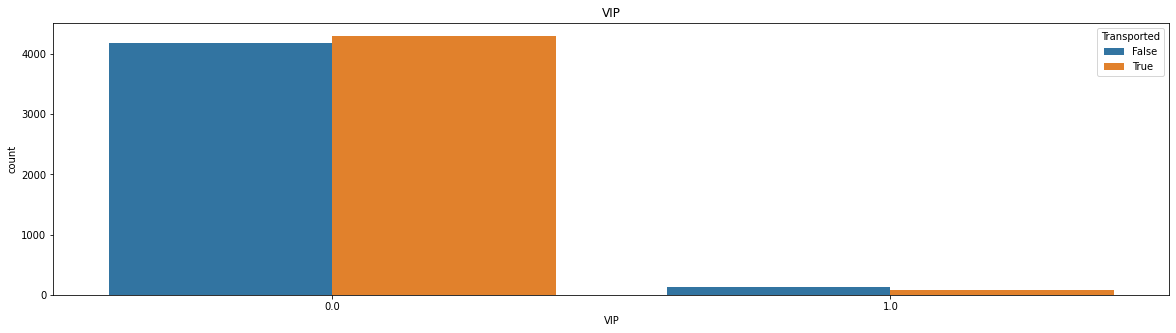

In [29]:
Target = update(Target)
fig=plt.figure(figsize=(20,5))
plt.subplot(1,1,1)
sns.countplot(data=Target, x='VIP', hue='Transported')
plt.title('VIP');

# MONEY

### A sleeping person cannot pay, just as a sleepless child cannot pay. All the remaining empty values ​​are filled with the average of the grouped features.

In [30]:
MoneyName = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for Names in MoneyName:
    print(f"{Names} #Lost after: , {df_train[Names].isnull().sum()}")
#     print(pd.crosstab(df_train[Names], df_train['CryoSleep']))
    for dataset in combine:
        indexMoneyCryoSleep = dataset.loc[(dataset[Names].isnull())&(dataset['CryoSleep']==1)].index
        for i in indexMoneyCryoSleep:
            dataset.loc[dataset['CryoSleep'].index == i, Names] = 0
    print(f"{Names} #Lost before: , {df_train[Names].isnull().sum()}")

RoomService #Lost after: , 263
RoomService #Lost before: , 170
FoodCourt #Lost after: , 289
FoodCourt #Lost before: , 180
ShoppingMall #Lost after: , 306
ShoppingMall #Lost before: , 175
Spa #Lost after: , 284
Spa #Lost before: , 177
VRDeck #Lost after: , 268
VRDeck #Lost before: , 177


In [31]:
for dataset in combine:
    for Names in MoneyName:
        print(df_train.groupby(['CryoSleep','Destination','HomePlanet','Age_group'])[Names].mean()[:3])
        print('#Lost before:', dataset[Names].isnull().sum())
        index=dataset.loc[dataset[Names].isnull(), Names].index
        dataset.loc[dataset[Names].isnull(),Names]=dataset.groupby(['CryoSleep',
                'Destination','HomePlanet','Age_group'])[Names].transform(lambda x: x.fillna(x.mean()))
        print('#Lost after:', dataset[Names].isnull().sum()) 

CryoSleep  Destination  HomePlanet  Age_group
0.00       55 Cancri e  Earth       Age12         0.00
                                    Age17       287.65
                                    Age25       205.00
Name: RoomService, dtype: float64
#Lost before: 170
#Lost after: 5
CryoSleep  Destination  HomePlanet  Age_group
0.00       55 Cancri e  Earth       Age12         0.00
                                    Age17       224.45
                                    Age25       186.96
Name: FoodCourt, dtype: float64
#Lost before: 180
#Lost after: 8
CryoSleep  Destination  HomePlanet  Age_group
0.00       55 Cancri e  Earth       Age12         0.00
                                    Age17       270.73
                                    Age25       233.99
Name: ShoppingMall, dtype: float64
#Lost before: 175
#Lost after: 16
CryoSleep  Destination  HomePlanet  Age_group
0.00       55 Cancri e  Earth       Age12         0.00
                                    Age17       133.56
          

In [32]:
for dataset in combine:
    for Names in MoneyName:
        print('#Lost before:', dataset[Names].isnull().sum())
        dataset[Names].fillna(0,inplace=True)
        print('#Lost after:', dataset[Names].isnull().sum())

#Lost before: 5
#Lost after: 0
#Lost before: 8
#Lost after: 0
#Lost before: 16
#Lost after: 0
#Lost before: 10
#Lost after: 0
#Lost before: 13
#Lost after: 0


### Getting rid of emissions

In [33]:
def outlier_thresholds(dataframe, col_name, q1 = 0.01, q3 = 0.99):
    Q1 = dataframe[col_name].quantile(q1)
    Q3 = dataframe[col_name].quantile(q3)
    IQR = Q3 - Q1
    low_limit = Q1 - 1.5 * IQR
    up_limit = Q3 + 1.5 * IQR
    
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)              
#     print(len(dataframe.loc[(dataframe[variable] < low_limit), variable]+len(dataframe.loc[(dataframe[variable] > up_limit), variable]))
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

    
for col in MoneyName:
    replace_with_thresholds(df_train, col)

### We form a sign, how many types of services the passenger used

In [34]:
df_train['MoneyCount'] = df_train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].replace(0, np.nan, inplace=False).count(axis=1, numeric_only=True)
df_train.drop(['Money1'], axis=1, inplace = True)

In [35]:
# #Schedule with rear suspension. It needs to be equalized in mass. Let's take a logarithm.
# Later it turned out that this slowed down, which means that the difference in the magnitude of the likelihood of survival.
# for col in ['Money','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']:
#     df_train[col]=np.log(1 + df_train[col])

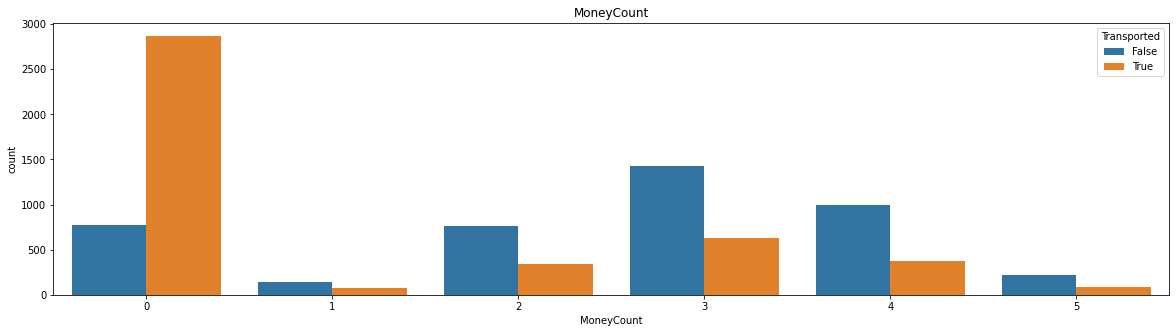

In [36]:
Target = update(Target)
fig=plt.figure(figsize=(20,5))
plt.subplot(1,1,1)
sns.countplot(data=Target, x='MoneyCount', hue='Transported')
plt.title('MoneyCount');

# CryoSleep

### As I wrote above, those who did not spend, they slept (not counting children)

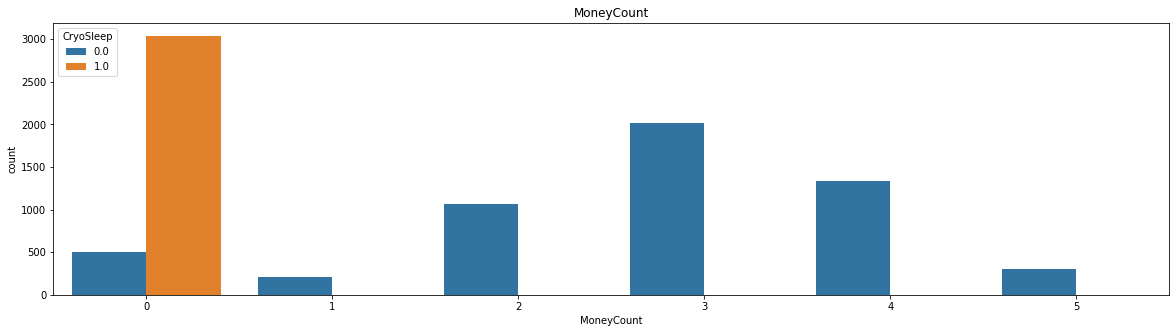

In [37]:
Target = update(Target)
fig=plt.figure(figsize=(20,5))
plt.subplot(1,1,1)
sns.countplot(data=Target, x='MoneyCount', hue='CryoSleep')
plt.title('MoneyCount');

In [38]:
#Money != 0 ----> CryoSleep = False
MoneyName = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
print('#Lost before:', dataset['CryoSleep'].isnull().sum())
for Names in MoneyName:
#     print(pd.crosstab(df_train[Names], df_train['CryoSleep']))
    for dataset in combine:
        indexMoneyCryoSleep = dataset.loc[(dataset['CryoSleep'].isnull())&(dataset[Names]>0)].index
        for i in indexMoneyCryoSleep:
            dataset.loc[dataset['CryoSleep'].index == i, 'CryoSleep'] = 0
print('#Lost after:', dataset['CryoSleep'].isnull().sum())

#Lost before: 310
#Lost after: 136


In [39]:
print(df_train.groupby(['MoneyCount','Age_group'])['CryoSleep'].mean())
print('#Lost before:', dataset['CryoSleep'].isnull().sum())
for Names in MoneyName:
    for dataset in combine:
        indexMoneyCryoSleep = dataset.loc[~(dataset['Age_group']=='Age12')&(dataset['MoneyCount']==0)&(dataset['CryoSleep'].isnull())].index
        for i in indexMoneyCryoSleep:
            dataset.loc[dataset['CryoSleep'].index == i, 'CryoSleep'] = 1
print('#Lost after:', dataset['CryoSleep'].isnull().sum())

MoneyCount  Age_group
0           Age12       0.49
            Age17       0.99
            Age25       0.96
            Age30       0.96
            Age50       0.97
            Age51+      0.96
1           Age17       0.00
            Age25       0.00
            Age30       0.00
            Age50       0.00
            Age51+      0.00
2           Age17       0.00
            Age25       0.00
            Age30       0.00
            Age50       0.00
            Age51+      0.00
3           Age17       0.00
            Age25       0.00
            Age30       0.00
            Age50       0.00
            Age51+      0.00
4           Age17       0.00
            Age25       0.00
            Age30       0.00
            Age50       0.00
            Age51+      0.00
5           Age17       0.00
            Age25       0.00
            Age30       0.00
            Age50       0.00
            Age51+      0.00
Name: CryoSleep, dtype: float64
#Lost before: 136
#Lost after: 30


In [40]:
for dataset in combine:
    print('#Lost before:', dataset['CryoSleep'].isnull().sum())
    dataset['CryoSleep'].fillna(1,inplace=True)
    print('#Lost after:', dataset['CryoSleep'].isnull().sum())

#Lost before: 30
#Lost after: 0


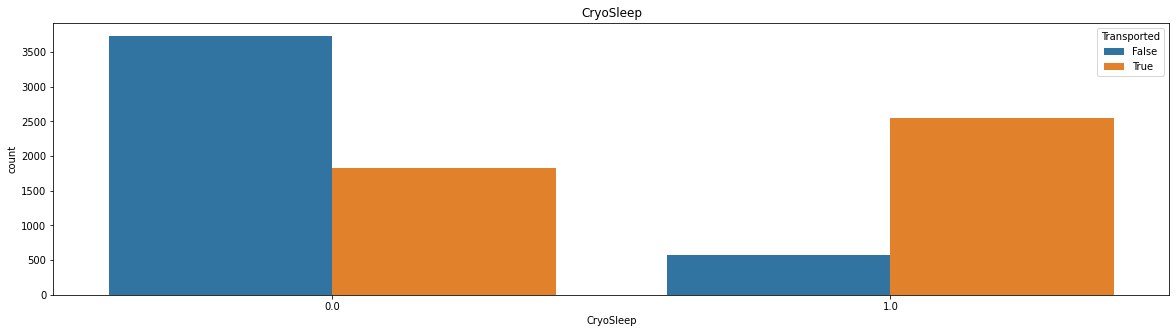

In [41]:
Target = update(Target)
fig=plt.figure(figsize=(20,5))
plt.subplot(1,1,1)
sns.countplot(data=Target, x='CryoSleep', hue='Transported')
plt.title('CryoSleep');

# DESTINATION

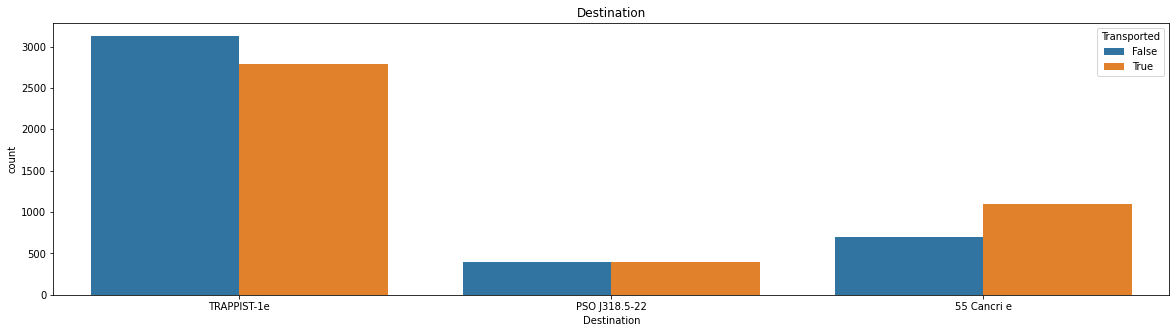

In [42]:
Target = update(Target)
fig=plt.figure(figsize=(20,5))
plt.subplot(1,1,1)
sns.countplot(data=Target, x='Destination', hue='Transported')
plt.title('Destination');

In [43]:
### Didn't find obvious dependencies.
for dataset in combine:
    print('#Lost before:', dataset['Destination'].isnull().sum())
    dataset['Destination'].fillna('TRAPPIST-1e' ,inplace=True)
    print('#Lost after:', dataset['Destination'].isnull().sum())

#Lost before: 274
#Lost after: 0


# ENCODING & SCALER

In [44]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, RobustScaler, StandardScaler, MinMaxScaler
categorical_cols= [
    'HomePlanet', 
    'Destination',
    'Cabin1',
    'ID2',
    'Age_group',
    'CabinCategory']
ordinal_encode=OrdinalEncoder()
df_train[categorical_cols] = ordinal_encode.fit_transform(df_train[categorical_cols])

In [45]:
features = ['CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'ID1', 'ID2', 'ID1_count',
       'Name1Count', 'NameLen1', 'Name2Count', 'NameLen', 'Cabin1', 'Cabin2',
       'Cabin3', 'RatioIDCabin', 'CabinCategory', 'NameSex', 'LuckyID',
       'Money', 'Age_group', 'MoneyCount']
Scaler = StandardScaler()
# Scaler = RobustScaler()
#Scaler = MinMaxScaler()
df_train[features] = Scaler.fit_transform(df_train[features])

In [46]:
Target = update(Target)
import plotly.express as px
corr = abs(Target.corr()['Transported']).sort_values().drop('Transported')
px.bar(corr, title='Absolute correlations of all features to Transported column')

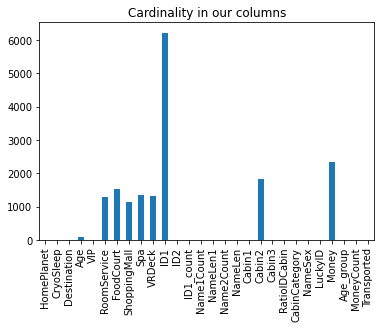

In [47]:
Target.nunique().plot.bar(title="Cardinality in our columns");

### To increase processing speed, remove complex features

In [48]:
Target.drop(['ID1',
             'Cabin2',
             'Age'],axis=1, inplace = True)

In [49]:
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression, LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier, LocalOutlierFactor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

from sklearn.exceptions import ConvergenceWarning
# from pandas_profiling import ProfileReport
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
# IterativeImputer

from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from itertools import permutations, combinations

## We are looking for basic models, immediately select the best 15 features for each.

### This can be done with a library, but we will do it manually, it's faster.

In [50]:
# %%time
# from sklearn.feature_selection import SequentialFeatureSelector
# # from mlxtend.feature_selection import ExhaustiveFeatureSelector
# model_fs = CatBoostClassifier(verbose=False)
# sf = SequentialFeatureSelector(model_fs, scoring='accuracy', direction = 'backward')
# sf.fit(X, y)

In [51]:
%%time
kfold = KFold(n_splits=5, shuffle=True, random_state=10) 

X = Target.drop('Transported',axis=1)
y = Target['Transported'].astype(int)

feature_names = X.columns
def base_models(X, y, scoring="accuracy"):
    print("Base Models....")
    classifiers = [
        ('SVC', SVC()),
        ('LSVC',  LinearSVC(max_iter=10000)),
        ('PC',  Perceptron()),
        ('SGDC',  SGDClassifier()),
        ('GB', GaussianNB()),
        ('GBM', GradientBoostingClassifier()),
        ('Adaboost', AdaBoostClassifier()),
        ('LR', LogisticRegression()),
        ("CART", DecisionTreeClassifier()),
        ("RF", RandomForestClassifier()),
        ('KNN', KNeighborsClassifier()),
        ("CatBoost" , CatBoostClassifier(verbose=False)),
        ('XGBoost', XGBClassifier()),
        ('LightGBM', LGBMClassifier(boosting_type = 'dart',objective='binary')),
                   ]
    best_feature = {}
    for name, classifier in classifiers:
        classifier = classifier.fit(X,y)
        cv_results = cross_validate(classifier, X, y, cv=kfold, scoring=scoring)
        print(f"{scoring}: {(cv_results['test_score'])} {round(cv_results['test_score'].mean(), 4)} ({name})")

        if name in {'XGBoost','LightGBM',"CatBoost"}:
            importances = classifier.feature_importances_
            indices = np.argsort(importances)[::-1]
            feature = []
#             print("Feature importances:")
            for f, idx in enumerate(indices[:15]):
#                 print("{:2d}. feature '{}' ({:.4f})".format(f + 1, feature_names[idx], importances[idx]))
                feature.append(feature_names[idx])
            best_feature[name] = feature
    return best_feature  
best_feature = base_models(X, y, scoring="accuracy")

Base Models....
accuracy: [0.8  0.77 0.8  0.81 0.81] 0.7982 (SVC)
accuracy: [0.8  0.77 0.8  0.81 0.8 ] 0.7969 (LSVC)
accuracy: [0.7  0.72 0.7  0.72 0.78] 0.7229 (PC)
accuracy: [0.8  0.76 0.79 0.8  0.8 ] 0.7903 (SGDC)
accuracy: [0.76 0.74 0.75 0.77 0.76] 0.7566 (GB)
accuracy: [0.8  0.78 0.79 0.81 0.82] 0.8004 (GBM)
accuracy: [0.8  0.77 0.79 0.8  0.8 ] 0.7922 (Adaboost)
accuracy: [0.8  0.77 0.8  0.81 0.8 ] 0.7967 (LR)
accuracy: [0.74 0.73 0.74 0.76 0.74] 0.7449 (CART)
accuracy: [0.8  0.77 0.8  0.8  0.81] 0.7951 (RF)
accuracy: [0.76 0.73 0.76 0.77 0.76] 0.7542 (KNN)
accuracy: [0.82 0.78 0.8  0.82 0.82] 0.8105 (CatBoost)
accuracy: [0.8  0.77 0.79 0.81 0.81] 0.797 (XGBoost)
accuracy: [0.81 0.79 0.8  0.82 0.82] 0.8085 (LightGBM)
CPU times: user 3min 5s, sys: 24.4 s, total: 3min 30s
Wall time: 1min 42s


In [52]:
best_feature.keys()

dict_keys(['CatBoost', 'XGBoost', 'LightGBM'])

## Without hyperparameters, CatBoost on cross-validation gives 81% accuracy.

In [53]:
%%time
  
Cat_param = {
            'iterations': range(500,1000,500),
#             'depth':range(4,10), 
#             'learning_rate':[0.01,0.05,0.1], 
#             'l2_leaf_reg': [0.05,0.01],
#             'gamma' : [0,1],
#             'max_depth': range(5, 10),
#             'border_count':[32,5,10,20,50,100,200],
#             'ctr_border_count':[50,5,10,20,100,200],
#             'thread_count': range(1,5),
#             'n_estimators': range(600,1500,300),
#             'subsample': np.linspace(1,10, num=10)       
#             "objective": ["Logloss", "CrossEntropy"],
#             'feature_border_type':['Median','Uniform','UniformAndQuantiles','GreedyLogSum','MaxLogSum','MinEntropy'],
#             'bootstrap_type':["Bayesian", "Bernoulli", "MVS"]
}

xgb_parameters = { 
#                 'booster': ['gbtree','gblinear'],
#                 'learning_rate'   : [0.2, 0.1, 0.05], 
#                 'max_depth'       : [3, 4, 8],
#                 'min_child_weight': [10, 15, 20],
                'n_estimators'    : range(50,100,50),
#                 'eval_metric'     : ['auc', 'mlogloss']
} 


lgbm_parameters = {
                    'n_estimators': range(70,110,10),  
#                     'max_depth': range(1,10),
#                     'num_leaves': range(2,15),
#                     'max_bin': range(3,40),
#                     'subsample': np.linspace(0,1, num=10),
#                     'metric': ['mse','mae'],
#                     'bagging_freq': range(3,50),
#                     'reg_lambda':np.linspace(0,1, num=20),
#                     'reg_alpha':np.linspace(0,1, num=20),
#                     'learning_rate': np.linspace(0.001,0.2, num=10),
#                     'feature_fraction': np.linspace(0.1, 0.8, num=25),
#                     'boosting_type': ['gbdt', 'dart', 'goss'],
                        }

classifiers = [
#         ('GB', GaussianNB(), param_grid_gnb),
#         ('PC',  Perceptron(), PC_param),
#         ('LR', LogisticRegression(solver='liblinear', penalty='l2'), param_grid_logit),
#         ('KNN', KNeighborsClassifier(), knn_params),
#         ('SVC', SVC(kernel='rbf',C = 12), SVC_param), 
#         ('LSVC',  LinearSVC(C = 0.1), LSVC_param),
#         ("CART", DecisionTreeClassifier(), cart_params),
#         ('Adaboost', AdaBoostClassifier(), Adaboost_params),
#         ('GBM', GradientBoostingClassifier(), gbm_parameters),
    ("CatBoost" , CatBoostClassifier(verbose=False),Cat_param),
    ('XGBoost', XGBClassifier(), xgb_parameters),
    ('LightGBM', LGBMClassifier(boosting_type = 'dart'), lgbm_parameters),
        ]


def hyperparameter_optimization(X, y, cv=kfold, scoring="accuracy"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        L = X[best_feature[name]]
#         L = X
        cv_results = cross_validate(classifier, L, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")
#         gs_best = RandomizedSearchCV(classifier, params, cv=cv, n_jobs=-1,n_iter=100, verbose=False).fit(L, y)
        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1,verbose=False).fit(L, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, L, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
        
    return best_models

best_models = hyperparameter_optimization(X, y, scoring="accuracy")

Hyperparameter Optimization....
########## CatBoost ##########
accuracy (Before): 0.8124
accuracy (After): 0.8112
CatBoost best params: {'iterations': 500}

########## XGBoost ##########
accuracy (Before): 0.8013
accuracy (After): 0.8019
XGBoost best params: {'n_estimators': 50}

########## LightGBM ##########
accuracy (Before): 0.8078
accuracy (After): 0.8085
LightGBM best params: {'n_estimators': 70}

CPU times: user 2min 25s, sys: 24.1 s, total: 2min 49s
Wall time: 1min 11s


## Each model is trained on its 15 features. Now, by common efforts, we determine our survivors.

# Friends! I am just learning and the selection of hyperparameters for me is still a big book that I have not opened, so this section in this notebook will be left out of brackets.

In [54]:
def voting_classifier(best_models, X, y):
    print("Voting Classifier...")

    voting_clf = VotingClassifier(estimators=[
                                            ('CatBoost', best_models["CatBoost"]),
                                              ('XGBoost', best_models["XGBoost"]),
                                              ('LightGBM', best_models["LightGBM"])
                                            ],voting='soft').fit(X, y)

    cv_results = cross_validate(voting_clf, X, y, cv=kfold, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

voting_clf = voting_classifier(best_models, X, y)

Voting Classifier...
Accuracy: 0.8083542715646136
F1Score: 0.8123521064294119
ROC_AUC: 0.901985653043482


# Friends! This is my first big work, I put my soul into it, I'm waiting for comments and feedback! It is very important for me!

In [55]:
df_test = df_train[8693:]
df_test.drop(['ID1','Cabin2','Age'],axis=1, inplace = True)
prediction = voting_clf.predict(df_test)
df_for_sub =pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
df_for_sub['Transported']=prediction
df_for_sub['Transported'] = df_for_sub['Transported'].astype(bool)
df_for_sub[['PassengerId','Transported']].to_csv('submission.csv', index=False)

In [56]:
''' Interesting library. The best result will not select, but allows you to understand the direction of the search. 
But if you have enough time, then it will select very optimal parameters.'''

# import optuna
# def objective(trial):
#     train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.2)
#     param = {
#         'objective': trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
#         'feature_border_type': trial.suggest_categorical("feature_border_type", 
#                                                          ['Median','Uniform',
#                                                           'UniformAndQuantiles','GreedyLogSum',
#                                                           'MaxLogSum','MinEntropy']),
# #         'iterations': trial.suggest_int("iterations", 100, 1200),
# #         'learning_rate':trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
# #         'depth':trial.suggest_int("depth", 4,8),
# #         'l2_leaf_reg':trial.suggest_float("l2_leaf_reg", 1e-8, 1, log=True),
#         'bootstrap_type':trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
# #         'random_strength':trial.suggest_float("random_strength", 1e-8, 1, log=True),
# #         'od_type':trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
# #         'od_wait':trial.suggest_int("od_wait", 10, 50),
#         'verbose' :False
#     }

# #     if param["bootstrap_type"] == "Bayesian":
# #         param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
# #     elif param["bootstrap_type"] == "Bernoulli":
# #         param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
#     model = CatBoostClassifier(**param)
    
#     model.fit(train_x, train_y)
#     y_pred = model.predict(valid_x)
    
#     return accuracy_score(valid_y, y_pred)

' Interesting library. The best result will not select, but allows you to understand the direction of the search. \nBut if you have enough time, then it will select very optimal parameters.'

In [57]:
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# from optuna.samplers import TPESampler
# sampler = TPESampler(seed=1)
# study = optuna.create_study(study_name="CatBoost", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=2500, timeout=18000)

In [58]:
# print("Number of finished trials: {}".format(len(study.trials)))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: {}".format(trial.value))

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

In [59]:
# df_test = df_train[8693:]
# model = CatBoostClassifier(**trial.params, verbose=False)
# model.fit(X, y)
# prediction = model.predict(df_test)
# cv_results = cross_validate(model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
# print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
# print(f"F1Score: {cv_results['test_f1'].mean()}")
# print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")